# Consumer Airfare Report: Table 6 - Contiguous State City-Pair Markets That Average At Least 10 Passengers Per Day
__Description:__  Available on the internet only, this table is an expanded version of Table 1 that lists all city-pair markets in the contiguous United States that average at least 10 passengers each day. All records are aggregated as directionless city pair markets. All traffic traveling in both directions is added together.

In [2]:
import requests
import pandas as pd
import numpy as np
import networkx as nx
from sodapy import Socrata
import yaml

## __Airport Data__

In [3]:
#Retrieve and clean airport data
url = 'http://ourairports.com/countries/US/airports.hxl'
airport_data = pd.read_csv(url, header=0).drop(0) #drop the first row --> contains duplicate column headers
airport_data = airport_data[airport_data['iso_country']=='US'] #keep only us airports
airport_data = airport_data[airport_data['type'].isin(['closed', 'seaplane_base', 'balloonport']) == False] #drop rows with values in 'isin' list
airport_data.drop(['id', 'ident', 'continent', 'iso_country', 'home_link', 'wikipedia_link'], axis=1, inplace=True) #Drop unneeded columns
airport_data['iso_region'] = airport_data['iso_region'].str.split('-').apply(lambda x: x[1]) #Delete 'US' prefix in 'iso_region' column data
airport_data['city_state'] = airport_data['municipality'] + ', ' + airport_data['iso_region']
airport_data['lat_long'] = tuple(zip(airport_data['longitude_deg'].astype(float), airport_data['latitude_deg'].astype(float)))
airport_data.head()

,type,name,latitude_deg,longitude_deg,elevation_ft,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,keywords,score,last_updated,city_state,lat_long
1,large_airport,Los Angeles International Airport,33.94250107,-118.4079971,125,CA,Los Angeles,1,KLAX,LAX,LAX,NaN,1335475,2010-01-23T11:27:55+00:00,"Los Angeles, CA","(-118.4079971, 33.94250107)"
2,large_airport,Chicago O'Hare International Airport,41.9786,-87.9048,672,IL,Chicago,1,KORD,ORD,ORD,"CHI, Orchard Place",1503175,2018-09-16T02:35:35+00:00,"Chicago, IL","(-87.9048, 41.9786)"
3,large_airport,John F Kennedy International Airport,40.63980103,-73.77890015,13,NY,New York,1,KJFK,JFK,JFK,"Manhattan, New York City, NYC, Idlewild",1052075,2010-01-23T11:27:54+00:00,"New York, NY","(-73.77890015, 40.63980103)"
4,large_airport,Hartsfield Jackson Atlanta International Airport,33.6367,-84.428101,1026,GA,Atlanta,1,KATL,ATL,ATL,NaN,2002475,2018-09-19T14:50:01+00:00,"Atlanta, GA","(-84.428101, 33.6367)"
5,large_airport,San Francisco International Airport,37.61899948120117,-122.375,13,CA,San Francisco,1,KSFO,SFO,SFO,"QSF, QBA",1112475,2008-06-13T14:30:04+00:00,"San Francisco, CA","(-122.375, 37.61899948120117)"


In [4]:
#Correct data types
airport_data[['latitude_deg', 'longitude_deg', 'elevation_ft', 'scheduled_service', 'score']] = airport_data[['latitude_deg', 'longitude_deg', 'elevation_ft', 'scheduled_service', 'score']].astype(float)

In [5]:
#Drop duplicates cities (only concerned about city_state and lat_long columns)
#We do lose some granularity in the data 
#(for example, O'Hare and Midway airports will now both be listed under 'Chicago'), but this was the only way to be able to get accurate lat/long data paired with prices
print('Pre-drop airport total: ', len(airport_data))
airport_data.drop_duplicates(subset=['city_state'], keep='first', inplace=True)
print('Post-drop airport total: ', len(airport_data))

Pre-drop airport total:  20724
Post-drop airport total:  11246


In [6]:
#Create a dictionary with city names (where airports are located) and their coordinates
airport_locations = {}
for city, location in zip(airport_data['city_state'], airport_data['lat_long']):
    airport_locations[city] = location

## __Route Data__

In [7]:
#Get Socrata app token via yaml method
def get_secret(authentication_file, website, secret):
    authentication_file = 'auth.yaml'
    with open(authentication_file, 'r') as config_file:
        config = yaml.load(config_file, Loader=yaml.FullLoader)
    
    return config[website][secret]

app_token = get_secret('auth.yaml', 'socrata', 'app_token')

print('Your app token is: {}.'.format(app_token))

Your app token is: RNarGQRjE9CCgxsLn6ZLvdUwK.


In [8]:
from sodapy import Socrata
domain = 'data.transportation.gov'
dataset_identifier = 'yj5y-b2ir'

with Socrata(domain, app_token) as client:
    print("Domain: {domain:}\nSession: {session:}\nURI Prefix: {uri_prefix:}\n".format(**client.__dict__))
    results = client.get(dataset_identifier, limit=1000000)
    df = pd.DataFrame.from_dict(results)
    
#Set passengers column type as float
df.passengers = df.passengers.astype(float)

#Drop unneeded columns & information
df = df.drop('tbl', axis=1)
df = df[df['passengers']>=50] #More than the number of passengers required to fill a Bombardier CRJ

df.head()

Domain: data.transportation.gov
Session: <requests.sessions.Session object at 0x000001CE2AD3C088>
URI Prefix: https://



,year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,...,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,location_1,location_2,tbl6pk,location_1_city,location_2_city
4,2019,3,33105,33244,"Cincinnati, OH","Memphis, TN",403,53.369565,284.6346232,DL,...,293.824024,AA,0.226069246,274.5513514,0,"{'type': 'Point', 'coordinates': [-84.513808, ...","{'type': 'Point', 'coordinates': [-90.052136, ...",201933310533244,NaN,NaN
9,2019,3,33198,32211,"Kansas City, MO","Las Vegas, NV",1139,800.000000,187.7240625,WN,...,208.4665745,NK,0.235326087,106.1499423,-1,"{'type': 'Point', 'coordinates': [-94.578559, ...","{'type': 'Point', 'coordinates': [-115.140597,...",201933319832211,NaN,NaN
10,2019,1,34100,30559,"Philadelphia, PA","Seattle, WA",2378,445.888889,268.9895839,AS,...,245.826061,AS,0.416895091,245.826061,-1,"{'type': 'Point', 'coordinates': [-75.16562, 3...","{'type': 'Point', 'coordinates': [-122.33028, ...",201913410030559,NaN,NaN
11,2019,3,31834,30559,"Fayetteville, AR","Seattle, WA",1625,77.500000,326.5067321,AA,...,339.1251889,UA,0.301542777,283.504186,0,"{'type': 'Point', 'coordinates': [-94.160583, ...","{'type': 'Point', 'coordinates': [-122.33028, ...",201933183430559,NaN,NaN
16,2019,3,33105,33214,"Cincinnati, OH","San Antonio, TX",1024,119.565217,201.4022727,AA,...,195.8167742,WN,0.207272727,163.7986842,0,"{'type': 'Point', 'coordinates': [-84.513808, ...","{'type': 'Point', 'coordinates': [-98.494599, ...",201933310533214,NaN,NaN


In [9]:
#Create edges dataframe (city pairs)
city_pairs = df[['city1', 'city2']].values.tolist()
city_pairs = np.asarray(city_pairs, dtype='object')
city_pairs[:10]

array([['Cincinnati, OH', 'Memphis, TN'],
       ['Kansas City, MO', 'Las Vegas, NV'],
       ['Philadelphia, PA', 'Seattle, WA'],
       ['Fayetteville, AR', 'Seattle, WA'],
       ['Cincinnati, OH', 'San Antonio, TX'],
       ['Houston, TX', 'Tucson, AZ'],
       ['Allentown/Bethlehem/Easton, PA', 'Sanford, FL'],
       ['Cedar Rapids/Iowa City, IA', 'Las Vegas, NV'],
       ['Birmingham, AL', 'Tampa, FL (Metropolitan Area)'],
       ['Birmingham, AL', 'Kansas City, MO']], dtype=object)

In [10]:
#Create nodes (airports) dataframe
unique_airports = airport_locations.keys()
print('Unique airports in list: ', len(unique_airports))

Unique airports in list:  11246


In [11]:
#Create a base-list containing all cities used in city-pairs
cities = list(set([item for sublist in city_pairs for item in sublist])) #flatten list
print('No. entries in cities: ', len(cities))

unique_airports = [airport for airport in unique_airports if airport in cities]
print('No. entries in unique_airports: ', len(unique_airports))

#Keep only edges with a cities in `unique_airports` list
graph_edges = []
for edge in city_pairs:
    if (edge[0] in (unique_airports)) and (edge[1] in (unique_airports)):
        graph_edges.append(edge)
print('No. entries in graph_edges: ', len(graph_edges))

#Reduce airports in `airport_locations` and `unique_airports` that are not in `city_pairs`
airport_locations = {key:value for key, value in airport_locations.items() if key in unique_airports}
print('No. entries in airport_locations: ', len(airport_locations))

No. entries in cities:  259
No. entries in unique_airports:  205
No. entries in graph_edges:  99135
No. entries in airport_locations:  205


In [12]:
#Plug edges and nodes into NetworkX package
g = nx.from_edgelist(graph_edges)
len(g.nodes()), len(g.edges())

(190, 1921)

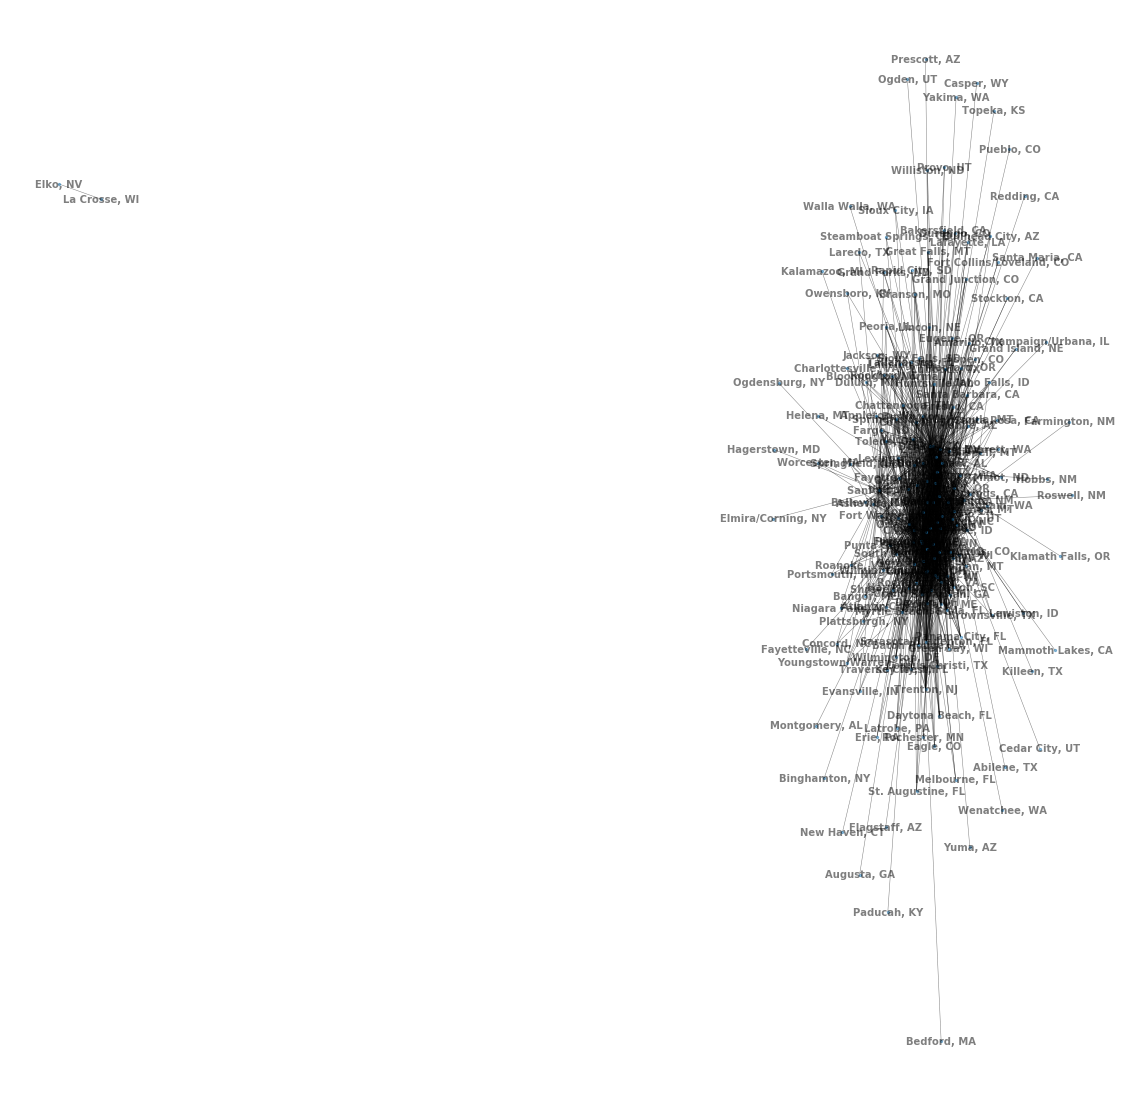

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
nx.draw_networkx(g, ax=ax, node_size=5, font_size=10, alpha=0.5, width=0.5)
ax.set_axis_off()

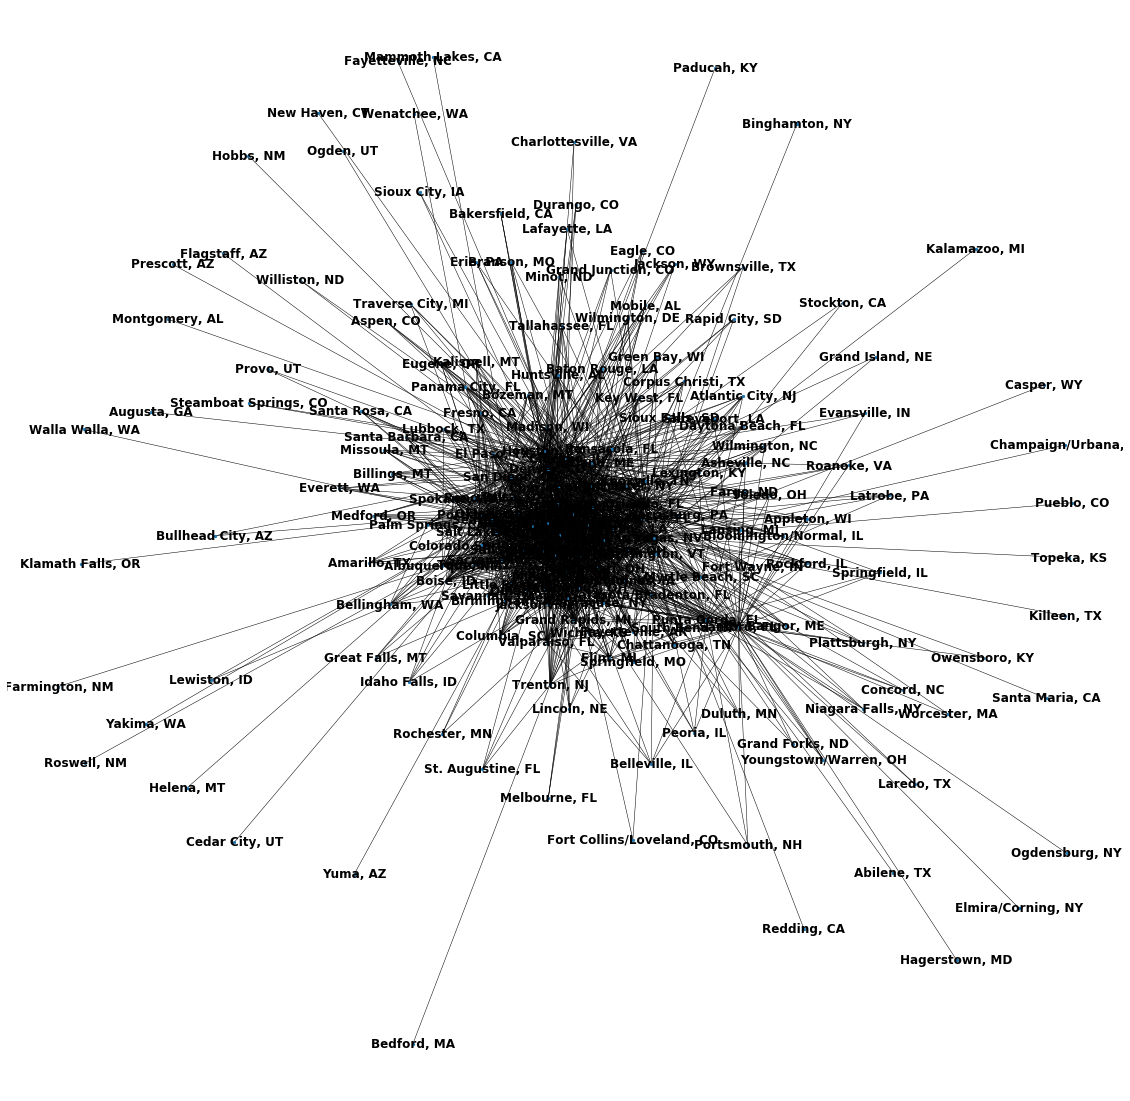

In [14]:
#Get just the main subgroup of the graph (the original `connected_component_subgraphs` method was depricated, so a temporary one was created here)
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
sg = next(connected_component_subgraphs(g))
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
nx.draw_networkx(sg, ax=ax, with_labels=True, node_size=5, width=0.5)
ax.set_axis_off()

In [15]:
#Get degrees of each node
deg = nx.degree(sg)
sizes = [5 * deg[iata] for iata in sg.nodes]

In [1]:
#Generate labels for the largest airports only (those with at least 150 connections or more)
def generate_labels(minimum_degrees):
    labels = {iata: iata if deg[iata] >= minimum_degrees else '' for iata in sg.nodes}
generate_labels(50)

NameError: name 'sg' is not defined

In [16]:
print('coordinates: ', len(airport_locations))
print('sizes: ', len(sizes))
print('labels: ', len(labels))

coordinates:  205
sizes:  188


NameError: name 'labels' is not defined

In [ ]:
import cartopy.crs as ccrs

#Create cartopy plot of network routes
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(20, 15), subplot_kw=dict(projection=crs)) #create a map (projection)
ax.coastlines() #add coastlines to the map
#Extent of continental US
# ax.set_extent([-125, -73, 25, 48])
#Superimpose the graph on the map based on coordinates_dict
nx.draw_networkx(sg, 
                 ax=ax, 
                 font_size=16, 
                 alpha=0.5, 
                 width=0.075, 
                 node_size=sizes, #represents degrees of each node ==> occurrances of each node (city) in 
                 labels=labels, 
                 pos=airport_locations, 
                 cmap=plt.cm.autumn)

## __Attempt at making Bokeh plot__
Add node attributes later

In [ ]:
bk_df.head(2)

In [194]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure#, gmap
from bokeh.models import GraphRenderer, Circle, StaticLayoutProvider, MultiLine, LabelSet, ColumnDataSource, HoverTool, Range1d, GMapOptions
from bokeh.models.graphs import from_networkx
from bokeh.tile_providers import get_provider, Vendors
from pyproj import Transformer, Proj, transform

output_notebook()

#Prep data
bk_df = pd.DataFrame.from_dict(airport_locations, orient='index') #Create a new dataframe
bk_df.reset_index(inplace=True)
bk_df.rename(columns={'index':'city', 0:'x_coords', 1:'y_coords'}, inplace=True)
bk_df['lat_long'] = tuple(zip(bk_df.x_coords, bk_df.y_coords))
bk_df = bk_df.merge(right=airport_data, how='inner', left_on='lat_long', right_on='lat_long')
bk_df.drop(columns=['iso_region', 'municipality', 'scheduled_service', 'gps_code', 'local_code', 'keywords', 'last_updated', 'latitude_deg', 'longitude_deg'], axis=1, inplace=True)

#Convert latitude/longitude to x/y coordinates for use in mercator projection(?)
# inProj = CRS.from_epsg(4326) #alternative to below)
inProj = pyproj.CRS('EPSG:4326')
outProj = pyproj.CRS('EPSG:3857') #4326 (wgs84) or 3857 (pseudo- (web) mercator)
# transformer = Transformer.from_crs(inProj, outProj, always_xy=True)
bk_df['mercator_lat_long'] = bk_df['lat_long'].apply(lambda x: transform(inProj, outProj, x[1], x[0]))
bk_df['mercator_x_coords'] = bk_df['mercator_lat_long'].apply(lambda x: x[0])
bk_df['mercator_y_coords'] = bk_df['mercator_lat_long'].apply(lambda x: x[1])

source = ColumnDataSource(bk_df)

buffer_box = 3 #padding for plot inside figure
bk_plot = figure(title='Route Map', 
#                  y_range=Range1d(bounds=(bk_df.x_coords.min()-buffer_box, bk_df.x_coords.max()+buffer_box)),
#                  x_range=Range1d(bounds=(bk_df.y_coords.min()-buffer_box, bk_df.y_coords.max()+buffer_box)),
                 x_range=(bk_df.mercator_x_coords.min()-buffer_box, bk_df.mercator_x_coords.max()+buffer_box), #plot may show up at (0, 0) if lat & long aren't in effect
                 y_range=(bk_df.mercator_y_coords.min()-buffer_box, bk_df.mercator_y_coords.max()+buffer_box),
                 x_axis_type = 'mercator', #generate axes with latitude & longitude labels
                 y_axis_type='mercator',
                 plot_width = 1000, 
                 plot_height = 600,     
                )

#Add map to background (coordinates don't match though)
# tile_provider = get_provider(Vendors.CARTODBPOSITRON)
# bk_plot.add_tile(tile_provider)
# center_lat = ((bk_df.x_coords.max()-bk_df.x_coords.min())/2)+bk_df.x_coords.min()
# center_long = ((bk_df.y_coords.max()-bk_df.y_coords.min())/2)+bk_df.y_coords.min()

# map_options = GMapOptions(lat=center_lat, lng=center_long, map_type='roadmap', zoom=4)
# GOOGLE_STATIC_MAP_API_KEY = get_secret('auth.yaml', 'google', 'api_key')
# print('Your app token is: {}'.format(GOOGLE_STATIC_MAP_API_KEY))
# bk_plot = gmap('GOOGLE_STATIC_MAP_API_KEY', map_options, title='USA Route Map')

#Further define the plot
bk_plot.background_fill_color = '#dddddd'
bk_plot.grid.grid_line_color = 'white'
bk_plot.xaxis.axis_label = 'Longitude (degrees W)'
bk_plot.yaxis.axis_label = 'Latitude (degrees N)'
# bk_plot.xaxis.axis_label_text_color = "#dddddd"

#Plotting network from networkx
fixed_layout = dict(zip(bk_df.city, np.array([list(a) for a in zip(bk_df.x_coords, bk_df.y_coords)]))) #I think the coordinates needed to be in format array(list of coordinates for dictionary key)?
graph = from_networkx(sg, nx.spring_layout)
fixed_layout_provider = StaticLayoutProvider(graph_layout=fixed_layout) #apply the geographical coordinates to network nodes (and edges?)
graph.layout_provider = fixed_layout_provider

#Set node attributes
node_size = {node[0]:(node[1]*0.25) for node in sg.degree}
node_labels = nx.get_node_attributes(sg, 'city')
nx.set_node_attributes(sg, node_size, name='node_size')
df_node_size = pd.DataFrame(node_size, columns=['city', 'node_size'], index=[0])
bk_df = bk_df.merge(df_node_size, on='city')
source.data = bk_df #update ColumnDataSource
# nx.set_node_attributes(sg, node_labels, name='node_color') #maybe set this to altitude?

#Set edge attributes

#Adjust node & edge colors & sizes
# x, y = zip(*graph.layout_provider.graph_layout.values())
bk_plot.circle(x='mercator_x_coords', y='mercator_y_coords', size='node_size', line_color=None, fill_alpha=0.8, source=source)
graph.node_renderer.glyph = Circle(size='node_size', line_color=None, fill_alpha=0.8)#, fill_color=
graph.edge_renderer.glyph = MultiLine(line_color='#CCCCCC', line_alpha=0.5, line_width=0.5)



#Add labels
# labels = generate_labels(100)
# city_labels_list = list(labels.values())
# label_source_data = bk_df[bk_df['city'].isin(city_labels_list)]
node_labels = LabelSet(x='mercator_x_coords', 
                       y='mercator_y_coords', 
                       level='glyph', 
                       text_font_size='10pt', 
                       text='city', 
                       y_offset=8,
                       x_offset=8,
                       background_fill_color='#dddddd', 
                       source=source, 
                       render_mode='canvas')

node_hover_tool = HoverTool(tooltips=[('city', '@index'), 
                                      ('mercator_lat_long', '@{mercator_lat_long}')])
bk_plot.add_tools(node_hover_tool)

#Optional Stuff
bk_plot.toolbar.autohide = True


#Render plots
bk_plot.add_layout(node_labels)
bk_plot.renderers.append(graph)

show(bk_plot)

Loading BokehJS ...

In [126]:
bk_df.head()

,city,x_coords,y_coords,lat_long,type,name,latitude_deg,longitude_deg,elevation_ft,iata_code,score,city_state,mercator_transform
0,"Chicago, IL",-87.904800,41.978600,"(-87.9048, 41.9786)",large_airport,Chicago O'Hare International Airport,41.978600,-87.904800,672.0,ORD,1503175.0,"Chicago, IL","(-9785517.574284555, 5157774.366665503)"
1,"Las Vegas, NV",-115.152000,36.080101,"(-115.1520004, 36.08010101)",large_airport,McCarran International Airport,36.080101,-115.152000,2181.0,LAS,1068475.0,"Las Vegas, NV","(-12818662.048354834, 4311648.752429698)"
2,"Orlando, FL",-81.308998,28.429399,"(-81.30899810791016, 28.429399490356445)",large_airport,Orlando International Airport,28.429399,-81.308998,96.0,MCO,1044075.0,"Orlando, FL","(-9051276.266283803, 3303219.9031648347)"
3,"Denver, CO",-104.672997,39.861698,"(-104.672996521, 39.861698150635)",large_airport,Denver International Airport,39.861698,-104.672997,5431.0,DEN,1103275.0,"Denver, CO","(-11652144.672523815, 4845864.938021944)"
4,"Phoenix, AZ",-112.012001,33.434299,"(-112.01200103759766, 33.43429946899414)",large_airport,Phoenix Sky Harbor International Airport,33.434299,-112.012001,1135.0,PHX,1060875.0,"Phoenix, AZ","(-12469118.918241002, 3953092.8574781558)"
